<a href="https://colab.research.google.com/github/elsioantunes/proc-video/blob/main/procVideoLab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processamento de video LAB 3 - conversão de cores
Objetivos:


1. Convert images from one color-space to another, like BGR ↔ Gray, BGR ↔ HSV, etc. $\color{#00DD00}{\text{OK}}$
2. Create an application to extract a colored object in a video $\color{#00DD00}{\text{OK}}$






##Open image

Mounted at /content/drive


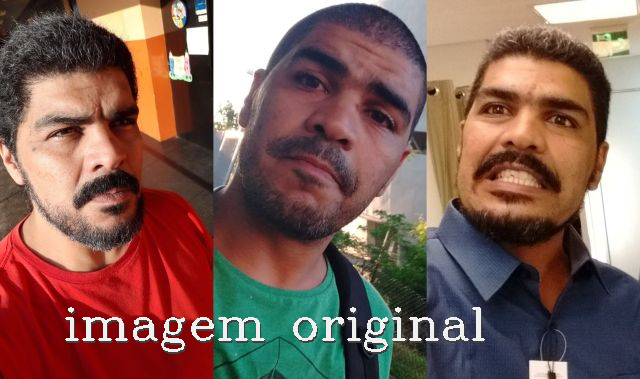

height:  379 width:  640 channels:  3


In [1]:
import numpy as np
import random
import cv2 as cv
from base64 import b64encode
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.display import HTML
 
#https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html
 
drive.mount('/content/drive')
img = cv.imread('/content/drive/MyDrive/((UFABC))/(proc video)/elsios.jpg')
height, width, channels = img.shape
 
myBgColor = (255, 245, 245)
 
def newEmptyImg(w=width, h=height, corRGB=myBgColor):
    b, g, r = corRGB
    emptyImg = np.zeros((h, w, 3), np.uint8)
    emptyImg[:, :] = (r, g, b)
    return emptyImg
 
def overlay(bg, img, x, y):
    h, w, _ = img.shape
    bg[y:h + y, x:w + x] = img
    return bg
 
def tableShow(m):
    hl, wl, h, w, _ = np.array(m).shape
    bg = newEmptyImg(w*wl + 5*wl+5, h*hl + 5*hl+5, myBgColor)
    for i, lin in enumerate(m):
        for j, col in enumerate(lin):
            bg = overlay(bg, col, 5 + (5 + width) * j, 5 + (5 + height) * i)
    return bg
 
def text(img, txt, w = int(width/10), h = int(9*height/10)):
    imgtmp = img.copy()
    cv.putText(imgtmp, txt, (w, h), cv.FONT_HERSHEY_COMPLEX, 1.5, (64, 64, 64), 2)
    cv.putText(imgtmp, txt, (w-1, h-2), cv.FONT_HERSHEY_COMPLEX, 1.5, (240, 240, 240), 2)
    return imgtmp
 
def show(img, title=""):
    return cv2_imshow(text(img, title))
 
nullSrc = newEmptyImg()
 
show(img, "imagem original")
print("height: ", height, "width: ", width, "channels: ", channels)

# Flags
O OpenCV possui centenas de opções de conversão de cor, enumeradas em constantes do parâmetro 'flag' que podemos visualizar com o seguinte código:

COLOR_BAYER_BG2BGR COLOR_BAYER_BG2BGRA COLOR_BAYER_BG2BGR_EA COLOR_BAYER_BG2BGR_VNG COLOR_BAYER_BG2GRAY 
COLOR_BAYER_BG2RGB COLOR_BAYER_BG2RGBA COLOR_BAYER_BG2RGB_EA COLOR_BAYER_BG2RGB_VNG COLOR_BAYER_GB2BGR COLOR_BAYER_GB2BGRA 
COLOR_BAYER_GB2BGR_EA COLOR_BAYER_GB2BGR_VNG COLOR_BAYER_GB2GRAY COLOR_BAYER_GB2RGB COLOR_BAYER_GB2RGBA COLOR_BAYER_GB2RGB_EA 
COLOR_BAYER_GB2RGB_VNG COLOR_BAYER_GR2BGR COLOR_BAYER_GR2BGRA COLOR_BAYER_GR2BGR_EA COLOR_BAYER_GR2BGR_VNG COLOR_BAYER_GR2GRAY 
COLOR_BAYER_GR2RGB COLOR_BAYER_GR2RGBA COLOR_BAYER_GR2RGB_EA COLOR_BAYER_GR2RGB_VNG COLOR_BAYER_RG2BGR COLOR_BAYER_RG2BGRA 
COLOR_BAYER_RG2BGR_EA COLOR_BAYER_RG2BGR_VNG COLOR_BAYER_RG2GRAY COLOR_BAYER_RG2RGB COLOR_BAYER_RG2RGBA COLOR_BAYER_RG2RGB_EA 
COLOR_BAYER_RG2RGB_VNG COLOR_BGR2BGR555 COLOR_BGR2BGR565 COLOR_BGR2BGRA COLOR_BGR2GRAY COLOR_BGR2HLS COLOR_BGR2HLS_FULL 
COLOR_BGR2HSV COLOR_BGR2HSV_FULL COLOR_BGR2LAB COLOR_BGR2LUV COLOR_BGR2Lab COLOR_BGR2Luv COLOR_BGR2RGB COLOR_BGR2RGBA 
COLOR_BGR2XYZ COLOR_BGR2Y

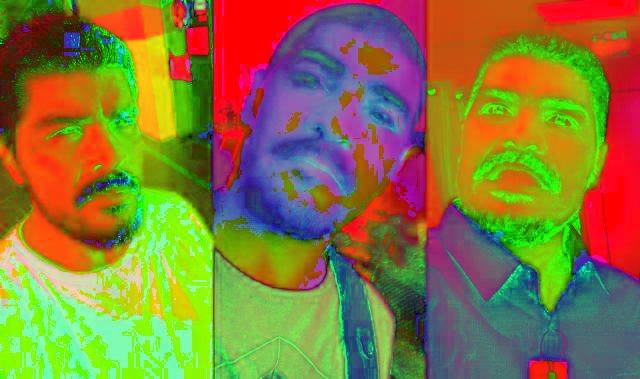

In [ ]:
lim = 0
for it in dir(cv):
    if it.startswith('COLOR_'):
        lim = lim + len(it)
        if lim > 100:
            lim = 0
            print()
        print (it, end=' ')

show(cv.cvtColor(img, cv.COLOR_BGR2HSV))

O comando `cv2_imshow` não trabalha com HSV e sim com BGR. A  informação retornada neste formato é (H)ue, (S)aturation e (V)alue, respectivamente matiz, saturação e (valor? de) brilho. Portanto, o sistema que pretende ler tais informações precisa representá-las corretamente. Mas foi interessante ver o efeito que os valores de cada componente da imagem HSV causam numa representação em canais RGB. 

# Um pouco de teoria
Existem diferentes sistemas de cores com diferentes características do espaço de cores que, dependendo da aplicação, pode querer enfatizar um fenômeno ou um processo de exibição, transmissão, compactação, transformação, harmonização etc.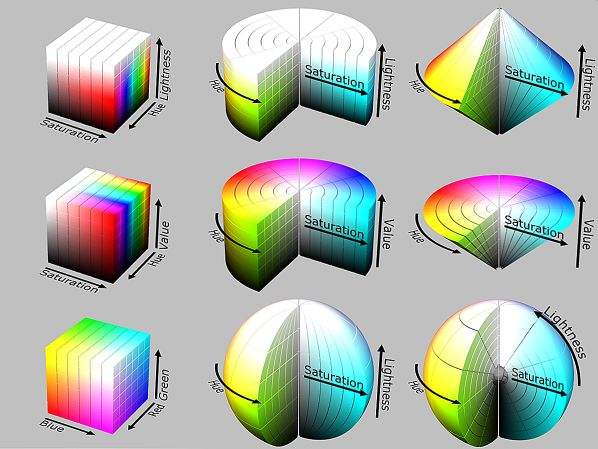 Por exemplo, para impressões em papel (branco) se faz mais útil o CMYK, um sistema *subtrativo* de cores que tem o amarelo, o ciano e o magenta como cores primárias e descreve o efeito de 'retirar' para obter determinada cor (absorção de fotons). No entanto, o sistema RGB (tem as cores vermelho, verde e azul como primárias) é um sistema aditivo e é utilizado fonte emissora em telas de dispositivos que produzem fotons exitando componentes a um estado de energia mais elevado, como ocorre em um tubo de raios catódicos ou em um led. 



# Luminância
O conversar com alguém que entende de fotografia, o ideal é não cravar termos pois pode levar uma bronca. Luminancia, Iluminância, Brilhança objetiva, Brilhança subjetiva... são tantos termos e, de fato, fenômenos diferentes com alguma semelhança e vários problemas de tradução que eu me reservo ao direito neste trabalho a não definir nenhum deles. 

O fato é que, para fins de edição e principalmente compressão de imagens, costuma-se separar a informação de uma imagem em informação de crominância e informação de luminância (chroma e luma). A luminância pode então ser interpretada como a intensidade de luz de cada pixel, podendo ter sido gerada por um objeto de cor clara (branca) ou pela insidência de luz. Ora, numa edição automática fica difícil pré-determinar esta diferença semântica de forma computacional. Trabalhos que envolvem inteligência artificial talvez resolvam isso. Se você é fotógrafo, me desculpe. Eu sou programador. 




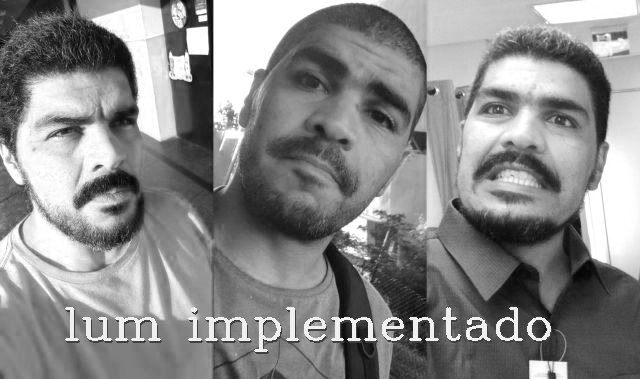

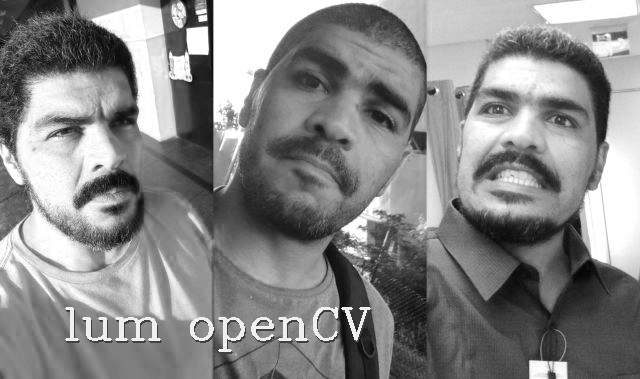

In [ ]:
def Lume(cor):
    return cor.max()
        
satTest1 = img.copy()
satTest3 = img.copy()
satTest2 = cv.cvtColor(img, cv.COLOR_BGR2HSV)

for h in range(height):
    for w in range(width):
        c = Lume(img[h][w])
        satTest1[h][w] = (c, c, c)
show(text(satTest1, "lum implementado"))

for h in range(height):
    for w in range(width):
        c = satTest2[h][w][2]
        satTest3[h][w] = (c, c, c)
show(text(satTest3, "lum openCV"))


São iguais. Mostrando que o HSV do openCV não usa nem a média (r, g, b)/3, nem a média (max + min)/2, nem a luma da wikipédia .3r + .59g + .11b nem a diferença. Eles usam o max(r, g, b)

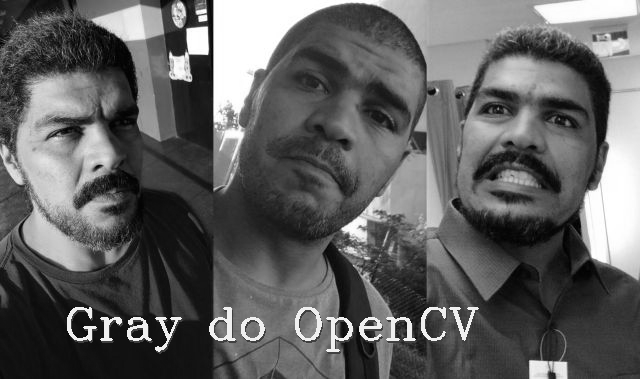

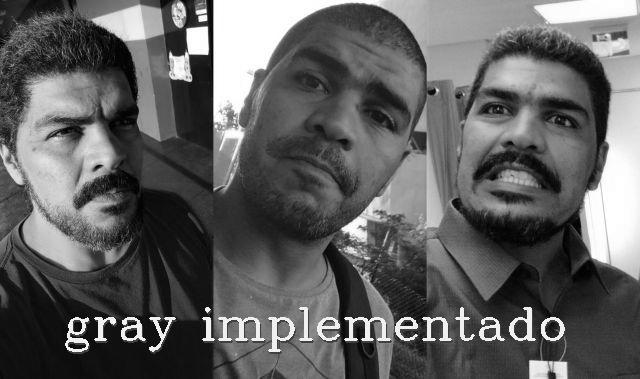

In [2]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
show(text(gray, "Gray do OpenCV"))

def Gray(cor):
    return np.uint8(.3*cor[0] + .59*cor[1] + .11*cor[2])
        
satTest1 = img.copy()
for h in range(height):
    for w in range(width):
        c = Gray(img[h][w])
        satTest1[h][w] = (c, c, c)
show(text(satTest1, "gray implementado"))

Olha só, o rgb2gray do OpenCV usa o luma da wikipédia, que não é o mesmo do canal de luma do rgb2hsv. Informação interessante pois são bem diferentes. 

# Matiz
Uma das três propriedades da cor que nos permite classificar o espectro de cores vermelho, verde, azul, amarelo, ciano e magenta, ignorando seus tons como vermelho escuro e vermelhor claro, verde acinzentado etc. Util em aplicações onde é importante distinguir cores, por exemplo, da face de um cubo mágico, desconsiderando o máximo possível as variações de sombra, característica que seria capturada nas outras duas componentes: saturação e iluminação.

In [ ]:
def Matiz(cor):
    b, g, r = np.int16(cor)
    maxcolor = max(r, g, b)
    mincolor = min(r, g, b)
    delta = maxcolor - mincolor
    matiz = 0 
    if delta > 0:
        if   r == maxcolor: matiz = (g - b) / delta + 0
        elif g == maxcolor: matiz = (b - r) / delta + 2
        elif b == maxcolor: matiz = (r - g) / delta + 4
        if matiz < 0: matiz += 6
    return np.uint8(matiz*30)
        
print(Matiz((0, 0, 255)))
print(Matiz((0,255,255)))
print(Matiz((0,255,0)))
print(Matiz((255,255,0)))
print(Matiz((255,0,0)))
print(Matiz((255,0,255)))

# só pra ter certeza de que a biblioteca faz o mesmo cálculo
print(cv.cvtColor(np.uint8([[[0, 0, 255]]]), cv.COLOR_BGR2HSV))
print(cv.cvtColor(np.uint8([[[0, 255, 255]]]), cv.COLOR_BGR2HSV))
print(cv.cvtColor(np.uint8([[[0, 255, 0]]]), cv.COLOR_BGR2HSV))
print(cv.cvtColor(np.uint8([[[255, 255, 0]]]), cv.COLOR_BGR2HSV))
print(cv.cvtColor(np.uint8([[[255, 0, 0]]]), cv.COLOR_BGR2HSV))
print(cv.cvtColor(np.uint8([[[255, 0, 255]]]), cv.COLOR_BGR2HSV))

0
30
60
90
120
150
[[[  0 255 255]]]
[[[ 30 255 255]]]
[[[ 60 255 255]]]
[[[ 90 255 255]]]
[[[120 255 255]]]
[[[150 255 255]]]


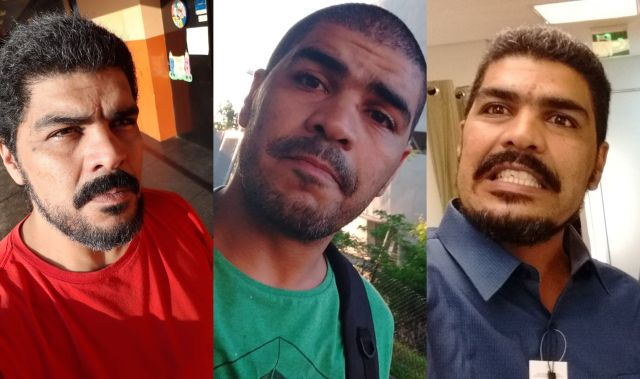

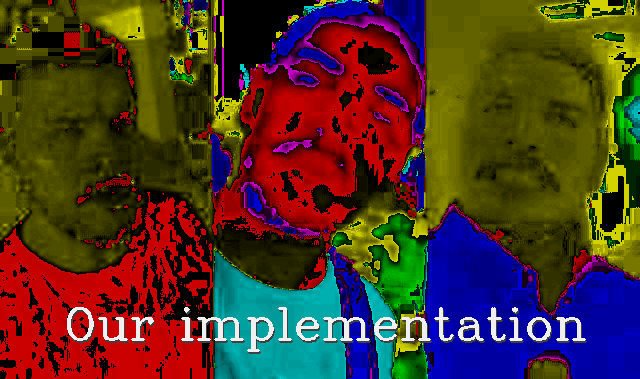

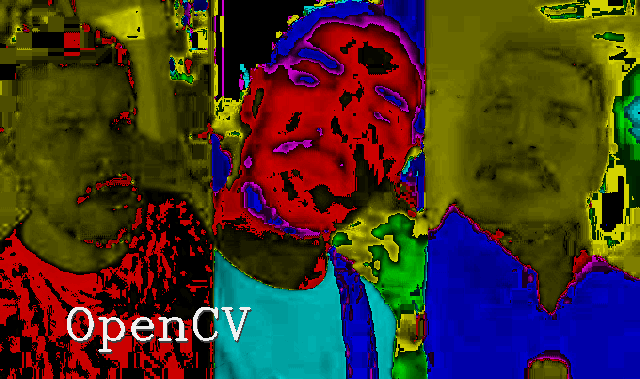

In [ ]:
show(img)
satTest1 = img.copy()
satTest3 = img.copy()
satTest2 = cv.cvtColor(img, cv.COLOR_BGR2HSV)

def separa(n):
    ret = (0, n, n)
    if   n > 150: ret = (0, 0, n-150)
    elif n > 120: ret = (n-120, 0, n-120)
    elif n > 90: ret = (n-90, 0, 0)
    elif n > 60: ret = (n-60, n-60, 0)
    elif n > 30: ret = (0, n-30, 0)
    elif n > 0: ret = (0, n, n)
    return np.uint8(ret)*7

for h in range(height):
    for w in range(width):
        satTest1[h][w] = separa(Matiz(img[h][w]))
show(text(satTest1, "Our implementation"))

for h in range(height):
    for w in range(width):
        satTest3[h][w] = separa(satTest2[h][w][0])
show(text(satTest3, "OpenCV"))


# Saturação
Saturação é a quantidade de crominância em relação ao ton de cinza equivalente (em luminância). Uma cor saturada é uma matiz pura. Quando dessaturamos a imagem, obtemos o chamado grayscale. 

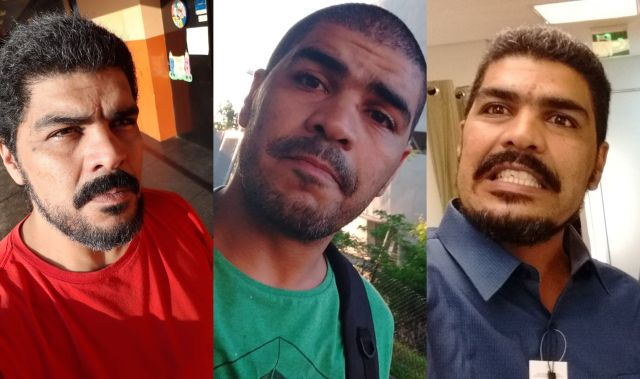

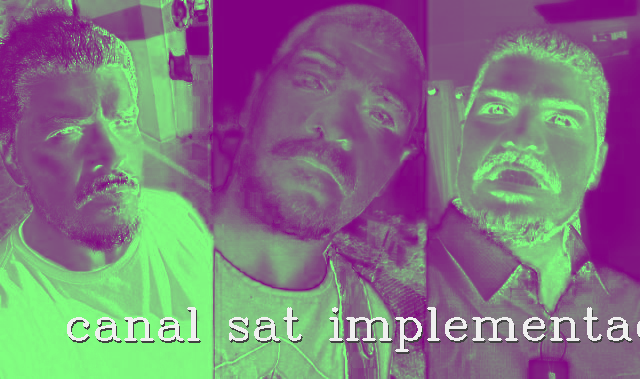

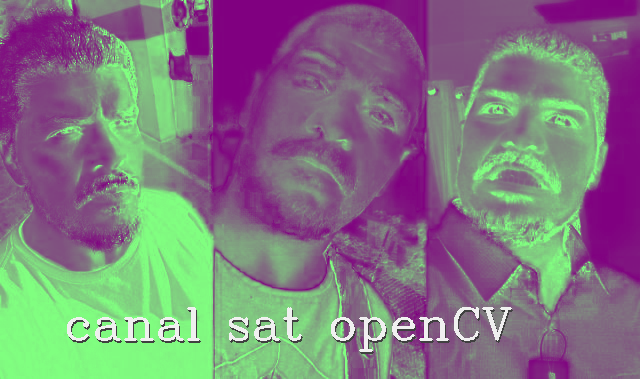

In [ ]:
show(img)

def Saturacao(cor):
    cor = np.int32(cor)
    maxcolor = cor.max()
    mincolor = cor.min()
    sat =  (maxcolor - mincolor)/maxcolor
    return np.uint8(255*sat)
        
satTest1 = img.copy()
satTest3 = img.copy()
satTest2 = cv.cvtColor(img, cv.COLOR_BGR2HSV)

for h in range(height):
    for w in range(width):
        #satTest1[h][w] = (Matiz(img[h][w]), Saturacao(img[h][w]), 128)
        satTest1[h][w] = (128, Saturacao(img[h][w]), 128)
show(text(satTest1, "canal sat implementado"))


for h in range(height):
    for w in range(width):
        #satTest3[h][w] = (satTest2[h][w][0], satTest2[h][w][1], 128)
        satTest3[h][w] = (128, satTest2[h][w][1], 128)
show(text(satTest3, "canal sat openCV"))


# Conclusão

Este experimento serviu para mostrar que o meu cálculo é praticamente o mesmo feito pela biblioteca openCV - claro, ambos estão seguindo a teoria. No entanto o resultado obtido não é o que eu esperava de uma imagem reduzida às cores R,G,B,Y,M,C. Quando aumentamos ao máximo o contraste de uma imagem no photoshop temos a nossa intuição satisfeita como esperado: 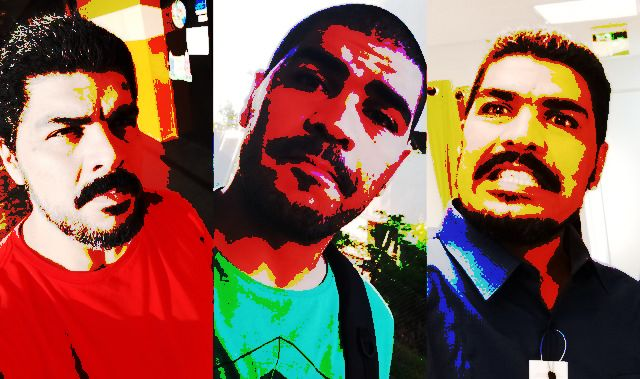 

O que nos leva a observar algumas coisas: primeiro que o cálculo tenta obter (sem sucesso) a crominância em regiões em que o pixel é preto ou branco, obtendo qualquer coisa. As componentes de luminância e saturação devem, portanto, ser fundamentais para determinação de faixas de cores do espectro. Talvez por isso tantas formas de interpretar o espaço de cores são disponibilizadas. Por fim, ficou claro que um algoritmo baseado em contraste seria muito mais eficiente.   


Página do github: https://elsioantunes.github.io/proc-video/

# Video


##Teste verde


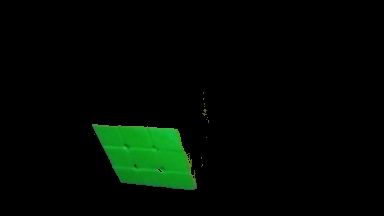

In [32]:
bgrB = 29 #@param {type:"slider", min:0, max:255}
bgrG = 162 #@param {type:"slider", min:0, max:255}
bgrR = 16 #@param {type:"slider", min:0, max:255}
bgr = np.array([bgrB, bgrG, bgrR])
dx = 74 #@param {type:"slider", min:10, max:80}

frameTest = frame[2]
minBGR = bgr - dx
maxBGR = bgr + dx

maskFrame = cv.inRange(frameTest, minBGR, maxBGR)
maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=maskFrame)
show(maskedFrame)


##Teste vermelho


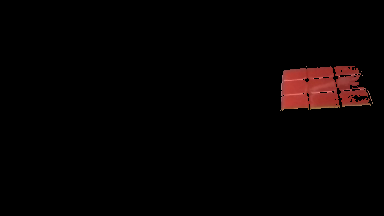

In [38]:
bgrB = 95 #@param {type:"slider", min:0, max:255}
bgrG = 70 #@param {type:"slider", min:0, max:255}
bgrR = 189 #@param {type:"slider", min:0, max:255}
bgr = np.array([bgrB, bgrG, bgrR])
dx = 57 #@param {type:"slider", min:10, max:80}

frameTest = frame[5]
minBGR = bgr - dx
maxBGR = bgr + dx

maskFrame = cv.inRange(frameTest, minBGR, maxBGR)
maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=maskFrame)
show(maskedFrame)


##Teste amarelo


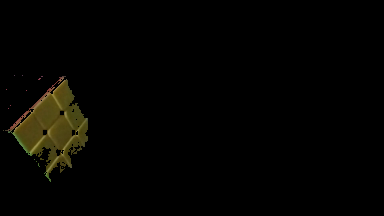

In [49]:
bgrB = 24 #@param {type:"slider", min:0, max:255}
bgrG = 109 #@param {type:"slider", min:0, max:255}
bgrR = 124 #@param {type:"slider", min:0, max:255}
bgr = np.array([bgrB, bgrG, bgrR])
dx = 54 #@param {type:"slider", min:10, max:80}

frameTest = frame[0]
minBGR = bgr - dx
maxBGR = bgr + dx

maskFrame = cv.inRange(frameTest, minBGR, maxBGR)
maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=maskFrame)
show(maskedFrame)

##Teste COLORIDO e máscara


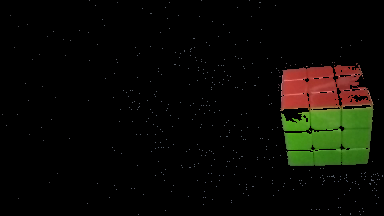

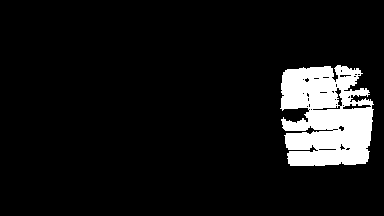

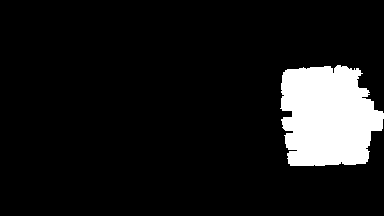

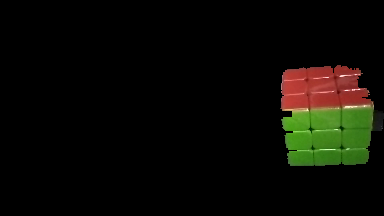

In [101]:
idx = 5 #@param {type:"slider", min:0, max:9}
frameTest = frame[idx]

# mascara verde
verde = np.array([29, 162, 16])
maskFrameGreen = cv.inRange(frameTest, verde-74, verde+74)

# mascara vermelha
vermelho = np.array([95, 70, 189])
maskFrameRed = cv.inRange(frameTest, vermelho-57, vermelho+57)

# mascara amarela
amarelo = np.array([24, 109, 124])
maskFrameYellow = cv.inRange(frameTest, amarelo-54, amarelo+54)

# junta mascaras
redOrGreen = cv.bitwise_or(maskFrameRed, maskFrameGreen)
redOrGreenOrYellow = cv.bitwise_or(redOrGreen, maskFrameYellow)

# teste da mascara
maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=redOrGreenOrYellow)
show(maskedFrame)

# limpa mascara por erosão > dilatação
kernel = cv.getStructuringElement(cv.MORPH_CROSS,(5,5))
maskOpen = cv.morphologyEx(redOrGreenOrYellow, cv.MORPH_OPEN, kernel)
show(maskOpen)

# tapa buracos com dilatação > erosão
kernel = cv.getStructuringElement(cv.MORPH_CROSS,(25,25))
maskClose = cv.morphologyEx(maskOpen, cv.MORPH_CLOSE, kernel)
show(maskClose)

# mascara final
maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=maskClose)
show(maskedFrame)

##Video final

frame count: 272.0
width, height, fps: 1920 1080 29.58401109883815
frame:0


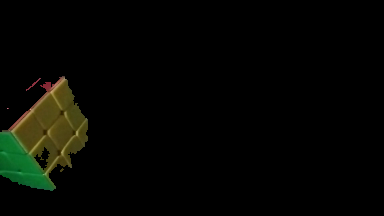

frame:1


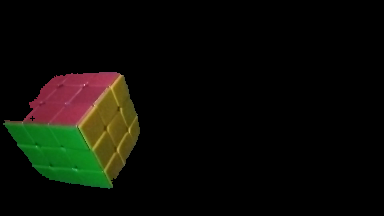

frame:2


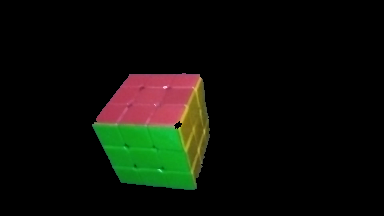

frame:3


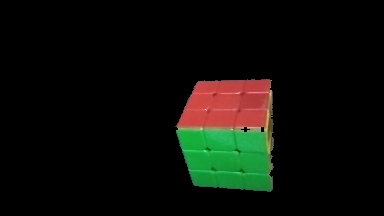

frame:4


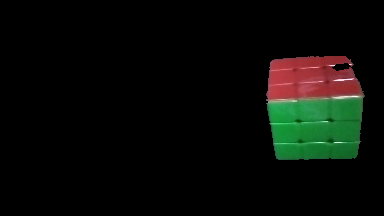

frame:5


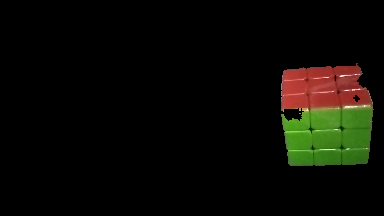

frame:6


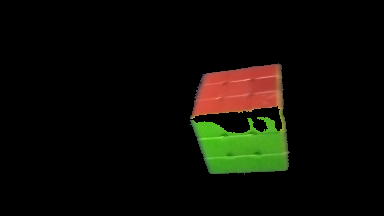

frame:7


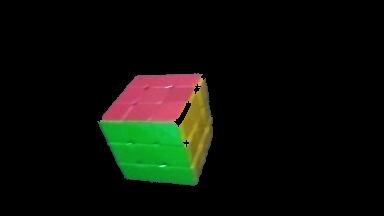

frame:8


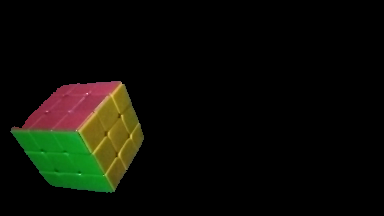

frame:9


In [107]:
def process(frameTest):
    verde = np.array([29, 162, 16])
    vermelho = np.array([95, 70, 189])
    amarelo = np.array([24, 109, 124])

    maskFrameGreen = cv.inRange(frameTest, verde-74, verde+74)
    maskFrameRed = cv.inRange(frameTest, vermelho-57, vermelho+57)
    maskFrameYellow = cv.inRange(frameTest, amarelo-54, amarelo+54)

    redOrGreen = cv.bitwise_or(maskFrameRed, maskFrameGreen)
    redOrGreenOrYellow = cv.bitwise_or(redOrGreen, maskFrameYellow)

    kernel = cv.getStructuringElement(cv.MORPH_CROSS,(5,5))
    maskOpen = cv.morphologyEx(redOrGreenOrYellow, cv.MORPH_OPEN, kernel)

    kernel = cv.getStructuringElement(cv.MORPH_CROSS,(25,25))
    maskClose = cv.morphologyEx(maskOpen, cv.MORPH_CLOSE, kernel)

    maskedFrame = cv.bitwise_and(frameTest, frameTest, mask=maskClose)
    return maskedFrame

inUrl = '/content/drive/MyDrive/((UFABC))/(proc video)/rubik4.mp4'
outUrl = '/content/drive/MyDrive/((UFABC))/(proc video)/teste.webm'
saida = None

cap = cv.VideoCapture(inUrl)
ret, frame = cap.read()
vheight, vwidth = frame.shape[:2]
fps = cap.get(cv.CAP_PROP_FPS)
print("frame count:", cap.get(cv.CAP_PROP_FRAME_COUNT))
print("width, height, fps:", vwidth, vheight, fps)
neww, newh = int(vwidth), int(vheight)

fourcc = cv.VideoWriter_fourcc(*'VP90')
 
x = 0
i = 0
frame = []
while True:
    ret, atualFrame = cap.read()
    if ret: 
        atualFrame = cv.resize(process(atualFrame), (384, 216))
        if saida == None:
            vheight, vwidth = atualFrame.shape[:2]
            saida = cv.VideoWriter(outUrl, fourcc, 25, (vwidth, vheight))
        saida.write(atualFrame)

        if (x % 30) == 0:
            print (f"frame:{i}")
            frame.append(atualFrame)
            show(atualFrame) 
            i = i + 1

        x = x + 1
    else: break

cap.release()
saida.release()

In [108]:
video = open(outUrl, 'rb').read()
vidDec = "data:video/mp4;base64," + b64encode(video).decode()
HTML(f'<video width={vwidth} controls><source src= "{vidDec}" type="video/mp4"></video>')

##teste

frame count: 272.0
width, height, fps: 1920 1080 29.58401109883815
frame:0


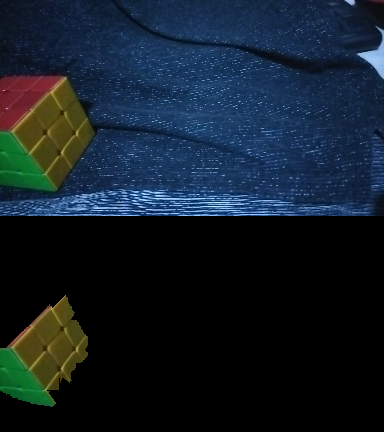

frame:1


frame:2


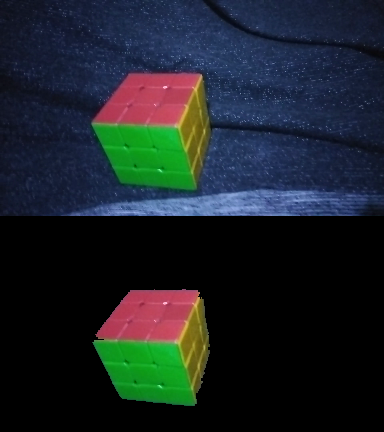

frame:3


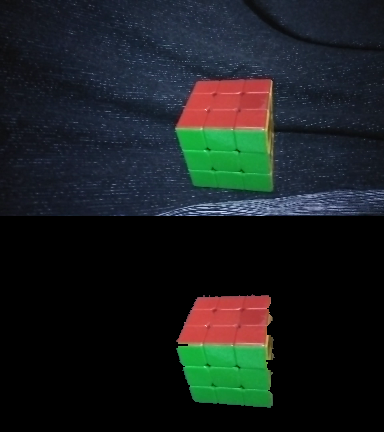

frame:4


frame:5


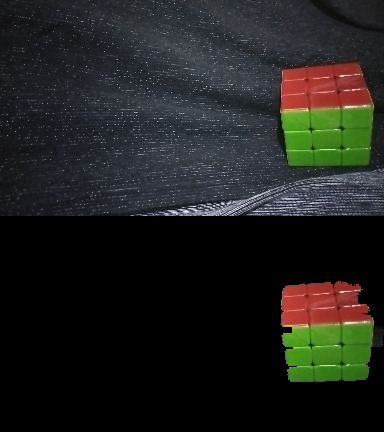

frame:6


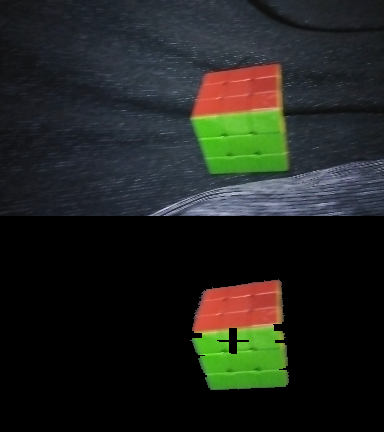

frame:7


frame:8


frame:9


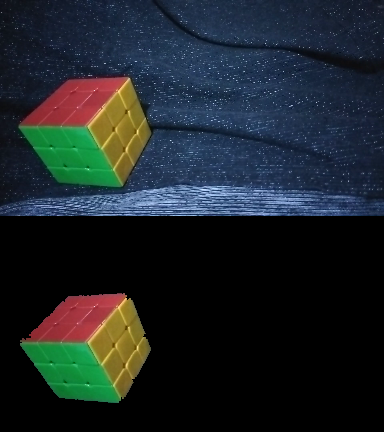

In [112]:
inUrl = '/content/drive/MyDrive/((UFABC))/(proc video)/rubik4.mp4'
outUrl = '/content/drive/MyDrive/((UFABC))/(proc video)/testeR4.mp4'
saida = None

cap = cv.VideoCapture(inUrl)
ret, frame = cap.read()
vheight, vwidth = frame.shape[:2]
fps = cap.get(cv.CAP_PROP_FPS)
print("frame count:", cap.get(cv.CAP_PROP_FRAME_COUNT))
print("width, height, fps:", vwidth, vheight, fps)
neww, newh = int(vwidth), int(vheight)

#fourcc = cv.VideoWriter_fourcc(*'VP90')
fourcc = cv.VideoWriter_fourcc(*'MP4V')
 
x = 0
i = 0
frame = []
while True:
    ret, atualFrame = cap.read()
    if ret: 
        atualFrame = cv.resize(atualFrame, (384, 216))
        processFrame = process(atualFrame)
        atualFrame = cv.vconcat([atualFrame, processFrame])

        if saida == None:
            vheight, vwidth = atualFrame.shape[:2]
            saida = cv.VideoWriter(outUrl, fourcc, 25, (vwidth, vheight))
        saida.write(atualFrame)

        if (x % 30) == 0:
            print (f"frame:{i}")
            frame.append(atualFrame)
            show(atualFrame) 
            i = i + 1

        x = x + 1
    else: break

cap.release()
saida.release()

#teste


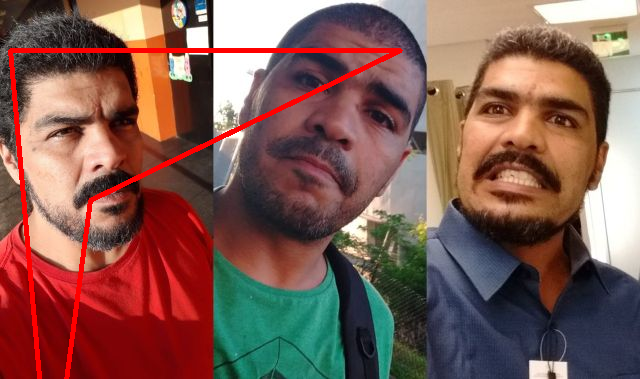

In [2]:
pts = np.array( [[10,50], [400,50], [90,200], [50,500]], np.int32)
# Let's now reshape our points in form  required by polylines
pts = pts.reshape((-1,1,2))
img2 = img.copy()
cv.polylines(img2, [pts], True, (0, 0, 255), 3)
show(img2)

In [10]:
hist = cv.calcHist([img], [0], None, [1], [0, 255])
hist

array([[236089.]], dtype=float32)